# MNIST Digit Recognition models with Normalization (BN+ L1, GN & LN)

In [1]:
from model import build_model
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torch.optim.lr_scheduler import StepLR,OneCycleLR
import numpy as np
import os

#!pip install torchsummary
from torchsummary import summary

# Reading MNIST data

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),                
                                       transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

## Create Train and Test Datasets

In [3]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True,transform=test_transforms)

In [4]:
n_train = len(train_data)
n_test = len(test_data)

print('Number of training samples: {0}'.format(n_train))
print('Number of test samples: {0}'.format(n_test))

Number of training samples: 60000
Number of test samples: 10000


## If available, set the device to "cuda"

In [5]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# Model Architecture

## Build the model from model.py "build_model" function

## Batch Normalization

In [6]:
model_bn = build_model('BN')

### Model Summary

In [7]:
model_bn = model_bn.to(device)
summary(model_bn, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7            [-1, 8, 24, 24]             128
         MaxPool2d-8            [-1, 8, 12, 12]               0
            Conv2d-9           [-1, 12, 10, 10]             864
             ReLU-10           [-1, 12, 10, 10]               0
      BatchNorm2d-11           [-1, 12, 10, 10]              24
           Conv2d-12             [-1, 16, 8, 8]           1,728
             ReLU-13             [-1, 16, 8, 8]               0
      BatchNorm2d-14             [-1, 1

## Group Normalization

In [8]:
model_gn = build_model('GN')

### Model Summary

In [9]:
model_gn = model_gn.to(device)
summary(model_gn, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
         GroupNorm-6           [-1, 16, 24, 24]              32
            Conv2d-7            [-1, 8, 24, 24]             128
         MaxPool2d-8            [-1, 8, 12, 12]               0
            Conv2d-9           [-1, 12, 10, 10]             864
             ReLU-10           [-1, 12, 10, 10]               0
        GroupNorm-11           [-1, 12, 10, 10]              24
           Conv2d-12             [-1, 16, 8, 8]           1,728
             ReLU-13             [-1, 16, 8, 8]               0
        GroupNorm-14             [-1, 1

## Layer Normalization

In [10]:
model_ln = build_model('LN')

### Model Summary

In [11]:
model_ln = model_ln.to(device)
summary(model_ln, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
         GroupNorm-6           [-1, 16, 24, 24]              32
            Conv2d-7            [-1, 8, 24, 24]             128
         MaxPool2d-8            [-1, 8, 12, 12]               0
            Conv2d-9           [-1, 12, 10, 10]             864
             ReLU-10           [-1, 12, 10, 10]               0
        GroupNorm-11           [-1, 12, 10, 10]              24
           Conv2d-12             [-1, 16, 8, 8]           1,728
             ReLU-13             [-1, 16, 8, 8]               0
        GroupNorm-14             [-1, 1

## Function to set seed for all random value generation

In [12]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

## Train Function

In [13]:
def train(model, device, train_loader, optimizer, scheduler, epoch, L1, l1_factor):
    model.train()
    epoch_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)

        if L1:
          L1_loss = nn.L1Loss(size_average=None, reduce=None, reduction='mean')
          reg_loss = 0 
          for param in model.parameters():
            zero_vector = torch.rand_like(param) * 0
            reg_loss += L1_loss(param,zero_vector)
          loss += l1_factor * reg_loss

        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    print(f'Train set: Average loss: {loss.item():.4f}, Accuracy: {100. * correct/len(train_loader.dataset):.2f}')
    train_loss = epoch_loss / len(train_loader)
    train_acc=100.*correct/len(train_loader.dataset)
    return train_loss, train_acc

## Test/Validation Function

In [14]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    test_pred = torch.LongTensor()
    target_pred = torch.LongTensor()
    target_data = torch.LongTensor()

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred_cpu = output.cpu().data.max(dim=1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            test_pred = torch.cat((test_pred, pred_cpu), dim=0)
            target_pred = torch.cat((target_pred, target.cpu()), dim=0)
            target_data = torch.cat((target_data, data.cpu()), dim=0)


    test_loss /= len(test_loader.dataset)
    test_acc = 100.*correct/len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.3f}, Accuracy: {100. * correct/len(test_loader.dataset):.2f}')
    return test_loss, test_acc, test_pred, target_pred, target_data

## Function for plotting misclassified images

In [15]:
def misclassification(predictions, targets, data, xtitle):
  pred = predictions.view(-1)
  target = targets.view(-1)

  index = 0
  misclassified_image = []

  for label, predict in zip(target, pred):
    if label != predict:
      misclassified_image.append(index)
    index += 1

  plt.figure(figsize=(10,5))
  plt.suptitle(xtitle + ' - Misclassified Images');

  for plot_index, bad_index in enumerate(misclassified_image[0:10]):
    p = plt.subplot(2, 5, plot_index+1)
    p.imshow(data[bad_index].reshape(28,28), cmap='gray')
    p.axis('off')
    p.set_title(f'Pred:{pred[bad_index]}, Actual:{target[bad_index]}')

## Main method for training and validating the model

In [16]:
def main(EPOCH, model, device, train_loader, test_loader, optimizer, scheduler, L1, l1_factor):
  train_loss_values = []
  test_loss_values = []
  train_acc_values = []
  test_acc_values = []

  for epoch in range(1, EPOCH + 1):
      print('\nEpoch {} : '.format(epoch))
      # train the model
      train_loss, train_acc = train(model, device, train_loader, optimizer, scheduler, epoch, L1, l1_factor)
      test_loss, test_acc, test_pred, target_pred, target_data = test(model, device, test_loader)

      train_loss_values.append(train_loss)
      test_loss_values.append(test_loss)

      train_acc_values.append(train_acc)
      test_acc_values.append(test_acc)

  return train_loss_values, test_loss_values, train_acc_values, test_acc_values, test_pred, target_pred, target_data

# Invoke the main method with all training parameters

In [17]:
if __name__=='__main__':

  EPOCH = 20
  batch_size = 64
  l1_factor = 0.0001

  cuda = torch.cuda.is_available()
  device = torch.device("cuda" if cuda else "cpu")

  seed_everything(1)

  kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, **kwargs)
  
  model = build_model('BN').to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.8)
  scheduler = OneCycleLR(optimizer, max_lr=0.015,epochs=20,steps_per_epoch=len(train_loader))
  
  print("------------------------------------------")
  print("Batch Normalization with L1 regularization")
  print("------------------------------------------")
  BN_train_loss, BN_test_loss, BN_train_acc, BN_test_acc, BN_test_pred, BN_target_pred, BN_target_data = main(EPOCH, model, device, train_loader, test_loader, optimizer, scheduler, True, l1_factor)

  model = build_model('GN').to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.8)
  scheduler = OneCycleLR(optimizer, max_lr=0.015,epochs=20,steps_per_epoch=len(train_loader))

  print("------------------------------------------")
  print("Group Normalization")
  print("------------------------------------------")
  GN_train_loss, GN_test_loss, GN_train_acc, GN_test_acc, GN_test_pred, GN_target_pred, GN_target_data = main(EPOCH, model, device, train_loader, test_loader, optimizer, scheduler, False, l1_factor)

  model = build_model('LN').to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.8)
  scheduler = OneCycleLR(optimizer, max_lr=0.015,epochs=20,steps_per_epoch=len(train_loader))

  print("------------------------------------------")
  print("Layer Normalization")
  print("------------------------------------------")
  LN_train_loss, LN_test_loss, LN_train_acc, LN_test_acc, LN_test_pred, LN_target_pred, LN_target_data = main(EPOCH, model, device, train_loader, test_loader, optimizer, scheduler, False, l1_factor)


------------------------------------------
Batch Normalization with L1 regularization
------------------------------------------

Epoch 1 : 
Train set: Average loss: 0.2748, Accuracy: 76.42

Test set: Average loss: 0.148, Accuracy: 97.17

Epoch 2 : 
Train set: Average loss: 0.0699, Accuracy: 96.55

Test set: Average loss: 0.070, Accuracy: 98.15

Epoch 3 : 
Train set: Average loss: 0.1106, Accuracy: 97.66

Test set: Average loss: 0.042, Accuracy: 98.77

Epoch 4 : 
Train set: Average loss: 0.0923, Accuracy: 98.09

Test set: Average loss: 0.042, Accuracy: 98.73

Epoch 5 : 
Train set: Average loss: 0.0054, Accuracy: 98.42

Test set: Average loss: 0.030, Accuracy: 99.09

Epoch 6 : 
Train set: Average loss: 0.1970, Accuracy: 98.64

Test set: Average loss: 0.025, Accuracy: 99.09

Epoch 7 : 
Train set: Average loss: 0.0123, Accuracy: 98.74

Test set: Average loss: 0.028, Accuracy: 99.15

Epoch 8 : 
Train set: Average loss: 0.0133, Accuracy: 98.86

Test set: Average loss: 0.029, Accuracy: 99.11

# Plotting the train and test accuracy & loss across each epoch

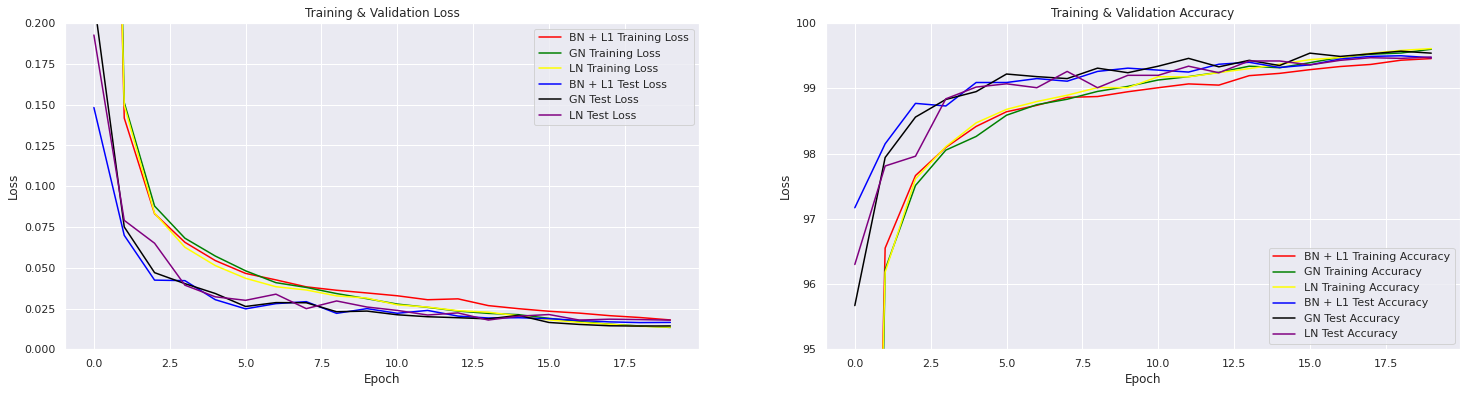

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='whitegrid')

# Increase the plot size and font size.
sns.set(font_scale=1)
plt.rcParams["figure.figsize"] = (25,6)

# Plot the learning curve.
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(np.array(BN_train_loss), 'red', label="BN + L1 Training Loss")
ax1.plot(np.array(GN_train_loss), 'green', label="GN Training Loss")
ax1.plot(np.array(LN_train_loss), 'yellow', label="LN Training Loss")
ax1.plot(np.array(BN_test_loss), 'blue', label="BN + L1 Test Loss")
ax1.plot(np.array(GN_test_loss), 'black', label="GN Test Loss")
ax1.plot(np.array(LN_test_loss), 'purple', label="LN Test Loss")

# Label the plot.
ax1.set_title("Training & Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_ylim(0,0.2)
ax1.legend()

ax2.plot(np.array(BN_train_acc), 'red', label="BN + L1 Training Accuracy")
ax2.plot(np.array(GN_train_acc), 'green', label="GN Training Accuracy")
ax2.plot(np.array(LN_train_acc), 'yellow', label="LN Training Accuracy")
ax2.plot(np.array(BN_test_acc), 'blue', label="BN + L1 Test Accuracy")
ax2.plot(np.array(GN_test_acc), 'black', label="GN Test Accuracy")
ax2.plot(np.array(LN_test_acc), 'purple', label="LN Test Accuracy")

# Label the plot.
ax2.set_title("Training & Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_ylim(95,100)
ax2.legend()

plt.show()

# Identify and plot 10 misclassified images from test data for all 3 models

## Batch Normalization + L1 Norm Misclassified Images

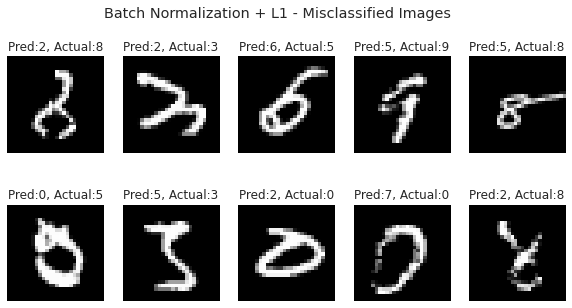

In [19]:
misclassification(BN_test_pred, BN_target_pred, BN_target_data, 'Batch Normalization + L1')

## Group Normalization Misclassified Images

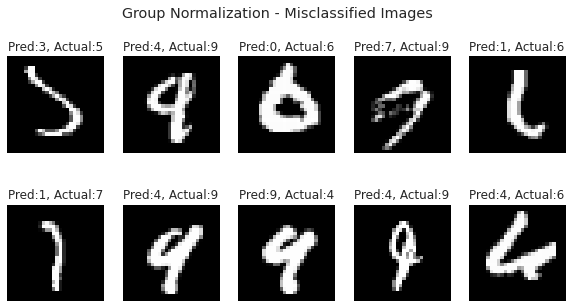

In [20]:
misclassification(GN_test_pred, GN_target_pred, GN_target_data, 'Group Normalization')

## Layer Normalization Misclassified Images

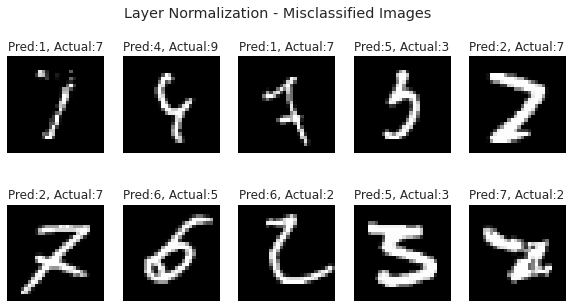

In [21]:
misclassification(LN_test_pred, LN_target_pred, LN_target_data, 'Layer Normalization')